# WebDataset

# WebDataset vs Dataset

- PyTorch `Dataset` performs random disk accesses to read individual files
- this is slow on both rotational disk drives and network file system
- `WebDataset` accesses data sequentially from storage and performs shuffling inline
- comparable to the `TFRecord` format with GoogleFS, but simpler and faster

In [5]:
%pylab inline
!date; hostname; whoami; pwd; curl https://ipinfo.io/hostname; nvidia-smi -L
from imp import reload
from torch import nn, optim
from torch.nn import functional as F
from torchmore import layers, flex
import torch
from torchvision import datasets, transforms
from torchvision.datasets import imagenet
import os, os.path
from torch.utils import data as torchdata
import helpers
import webdataset as wds
if "GZIP" in os.environ: del os.environ["GZIP"]

Populating the interactive namespace from numpy and matplotlib
Tue Dec 10 00:13:57 PST 2019
sedna
tmb
/home/tmb/exp/bigdata19
c-67-170-103-104.hsd1.wa.comcast.net
GPU 0: GeForce GTX 1080 Ti (UUID: GPU-2d5cf167-db75-89ec-c6f7-5639237768ce)


# ImageNet Dataset

By default, the ImageNet dataset is stored as individual files on disk.

In [5]:
for p in "/home/tmb/data/imagenet-raw:/data19/imagenet-raw".split(":"):
    p += "/ILSVRC2012_devkit_t12"
    if os.path.exists(p):
        devkit_root12 = p
        break
print(devkit_root12)

/data19/imagenet-raw/ILSVRC2012_devkit_t12


# WebDataset

- Web datasets are stored as collections of shards under URLs.
- The are usually stored as `sharded tar files` (compared to TFRecord)

In [6]:
imagenet_bucket = "http://storage.googleapis.com/lpr-imagenet"
imagenet_url = imagenet_bucket+"/imagenet_train-{0000..0147}.tgz"
print(imagenet_url)

http://storage.googleapis.com/lpr-imagenet/imagenet_train-{0000..0147}.tgz


# WebDataset Format

Datasets are just stored as regular files inside a `tar` archive for `WebDataset`.

In [6]:
!curl -s http://storage.googleapis.com/lpr-imagenet/imagenet_train-0000.tgz | tar -ztvf - | sed 10q

-rw-rw-rw- bigdata/bigdata   3 2019-06-08 12:12 n03788365_17158.cls
-rw-rw-rw- bigdata/bigdata 75884 2019-06-08 12:12 n03788365_17158.jpg
-rw-rw-rw- bigdata/bigdata   382 2019-06-08 12:12 n03788365_17158.json
-rw-rw-rw- bigdata/bigdata     3 2019-06-08 12:12 n03000247_49831.cls
-rw-rw-rw- bigdata/bigdata 57068 2019-06-08 12:12 n03000247_49831.jpg
-rw-rw-rw- bigdata/bigdata   104 2019-06-08 12:12 n03000247_49831.json
-rw-rw-rw- bigdata/bigdata     3 2019-06-08 12:12 n03000247_22907.cls
-rw-rw-rw- bigdata/bigdata 97447 2019-06-08 12:12 n03000247_22907.jpg
-rw-rw-rw- bigdata/bigdata   450 2019-06-08 12:12 n03000247_22907.json
-rw-rw-rw- bigdata/bigdata     3 2019-06-08 12:12 n04597913_10741.cls
^C


# Augmentation

We use standard ImageNet augmentation functions.

In [7]:
augmentation_function = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

def class_minus_1(x): return x-1

# Creating the Datasets

- The built-in dataset takes longer to start because it reads all the metadata first.
- `WebDataset` has a few more options.

In [10]:
%%time
training_ds = datasets.ImageNet(devkit_root12, transform=augmentation_function)

CPU times: user 3.64 s, sys: 368 ms, total: 4.01 s
Wall time: 4.01 s


In [11]:
%%time
training_wds = wds.WebDataset(imagenet_url, extensions="jpg cls", decoder="pil", shuffle=100,
                              transforms=[augmentation_function, class_minus_1])

CPU times: user 1.14 ms, sys: 0 ns, total: 1.14 ms
Wall time: 1.15 ms


# Creating the DataLoader

Creating the `DataLoader` from the two datasets is very similar, except we don't shuffle with `WebDataset`.

In [12]:
%%time
training_dl = torchdata.DataLoader(training_ds, batch_size=256, shuffle=True, num_workers=8)

CPU times: user 126 µs, sys: 13 µs, total: 139 µs
Wall time: 146 µs


In [13]:
%%time
training_wdl = torchdata.DataLoader(training_wds, batch_size=256, num_workers=8)

CPU times: user 78 µs, sys: 8 µs, total: 86 µs
Wall time: 93.2 µs


# Loading a Batch (torchvision)

torch.Size([256, 3, 224, 224]) torch.float32 tensor(0.) tensor(1.) tensor(7) tensor(999)


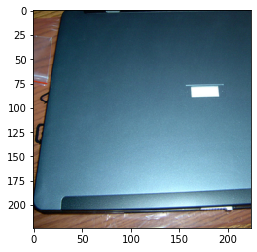

In [14]:
image_batch, cls_batch = next(iter(training_dl))
print(image_batch.shape, image_batch.dtype, image_batch.min(), image_batch.max(), cls_batch.min(), cls_batch.max())
imshow(image_batch[0].permute(1, 2, 0).numpy())

# Loading a Batch (WebDataset)

torch.Size([256, 3, 224, 224]) torch.float32 tensor(0.) tensor(1.) tensor(0) tensor(989)


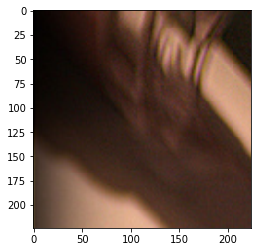

In [15]:
image_batch, cls_batch = next(iter(training_wdl))
print(image_batch.shape, image_batch.dtype, image_batch.min(), image_batch.max(), cls_batch.min(), cls_batch.max())
imshow(image_batch[0].permute(1, 2, 0).numpy())

# Performance Comparison

`WebDataset` over a network connection to Google is nearly six times faster than local disk.

In [17]:
from itertools import islice
timers = helpers.Timers()
with timers.files:
    for i, batch in enumerate(training_dl):
        if i==5: break
with timers.wds:
    for i, batch in enumerate(training_wdl):
        if i==5: break
print(timers, timers.files.value()/timers.wds.value())

files:4.02e+01
wds:6.84e+00 5.875861271116819


# Training

Training with `WebDataset` is otherwise indistinguishable from a regular dataset. Note that I/O does not dominate training anymore.

In [24]:
from torchvision import models
def make_model():
    return models.resnet18()
model = make_model()
model.cuda();

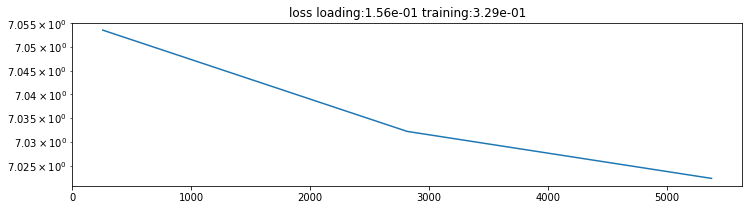

<Figure size 864x216 with 0 Axes>

In [25]:
reload(helpers)
trainer = helpers.Trainer(model)
trainer.set_lr(1e-3)
trainer.train_for(10000, training_wdl)
clf()

# WebDataset

- almost a drop-in alternative to `DataSet`
- fully compatible with existing PyTorch data loaders and training pipelines
- much faster I/O than file-based datasets
- easy conversion